In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter 
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, mean_squared_error, r2_score

# **Inspect Data**

In [3]:
file_path = '/kaggle/input/cancer-prediction-dataset/The_Cancer_data_1500_V2.csv'
df = pd.read_csv(file_path)

In [4]:
print("Rows:",df.shape[0])
print("Columns:",df.shape[1])

Rows: 1500
Columns: 9


In [4]:
df.head(10)

,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis
0,58,1,16.085313,0,1,8.146251,4.148219,1,1
1,71,0,30.828784,0,1,9.361630,3.519683,0,0
2,48,1,38.785084,0,2,5.135179,4.728368,0,1
3,34,0,30.040296,0,0,9.502792,2.044636,0,0
4,62,1,35.479721,0,0,5.356890,3.309849,0,1
5,27,0,37.105162,0,1,3.941905,2.324274,0,0
6,80,1,20.701994,0,0,8.482031,3.152943,0,0
7,40,0,20.301121,1,0,4.929827,2.247995,1,0
8,58,1,30.274525,0,1,4.719025,0.943161,1,1
9,77,0,25.275712,0,1,4.903125,2.539487,0,0


In [11]:
feature_list = list(df.columns)[:-1]
feature_list

['Age',
 'Gender',
 'BMI',
 'Smoking',
 'GeneticRisk',
 'PhysicalActivity',
 'AlcoholIntake',
 'CancerHistory']

In [6]:
df.dtypes
# all numerical 

Age                   int64
Gender                int64
BMI                 float64
Smoking               int64
GeneticRisk           int64
PhysicalActivity    float64
AlcoholIntake       float64
CancerHistory         int64
Diagnosis             int64
dtype: object

In [7]:
df.isnull().values.any()
# no missing values

False

In [8]:
df['Diagnosis'].describe()

count    1500.000000
mean        0.371333
std         0.483322
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Diagnosis, dtype: float64

# **Visualizing Relationships Between Features and Diagnosis**

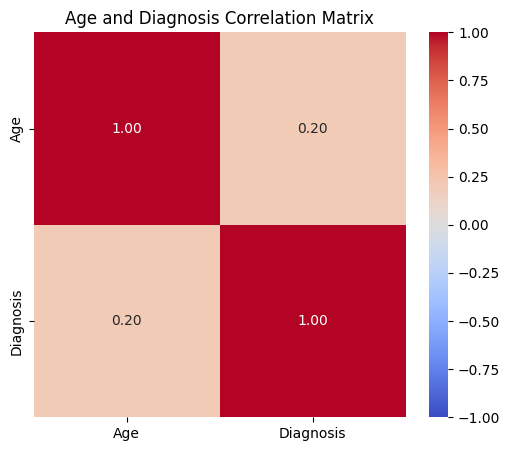

In [24]:
plt.figure(figsize=(6, 5))

sns.heatmap(df[['Age', 'Diagnosis']].corr(), cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("Age and Diagnosis Correlation Matrix")
plt.show()

The correlation matrix shows a positive correlation between age and diagnosis. I wanted to see if a potentially skewed  distrubtion of ages across the data set could have been influencing this result so I created a histogram. 

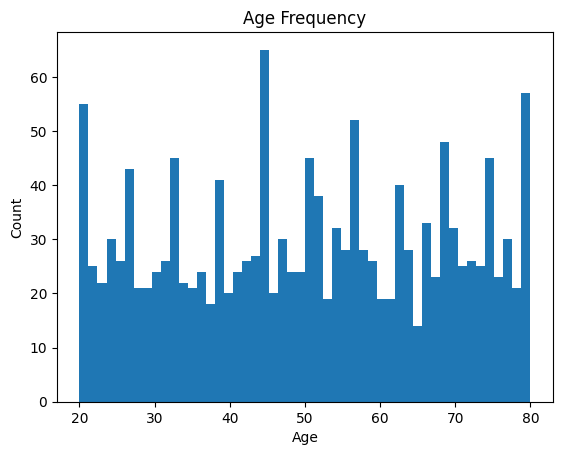

In [71]:
age_list  = list(df['Age'])
plt.hist(age_list, bins = 50)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Frequency')
plt.show()

In [46]:
df['Age'].describe()

count    1500.000000
mean       50.320000
std        17.640968
min        20.000000
25%        35.000000
50%        51.000000
75%        66.000000
max        80.000000
Name: Age, dtype: float64

The age ranges are pretty evenly distributed throughout the data implying that as age increases, there is a greater risk of cancer. This is in alignment with cancer research. According to the National Cancer Institute, advancing age is the most important risk factor for cancer overall and for many individual cancer types. 

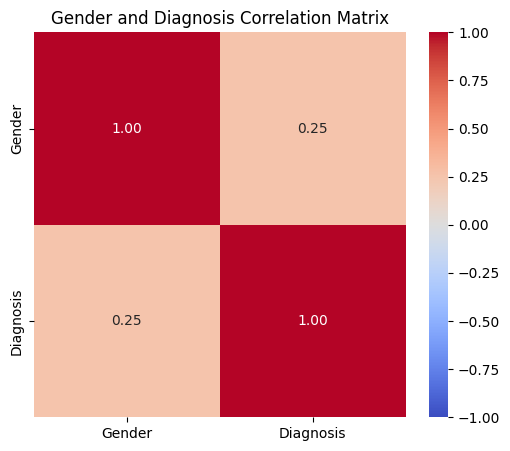

In [25]:
plt.figure(figsize=(6, 5))

sns.heatmap(df[['Gender', 'Diagnosis']].corr(), cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("Gender and Diagnosis Correlation Matrix")
plt.show()

1 represents female and 0 represents male. This correlation matrix implies females have a greater risk of cancer. However, the research I found stated the opposite. Harvard Magazine stated that "one in two men will develop some form of the disease in a lifetime, compared with one in three women," so I wanted to take a deeper delve into why the data was displaying these results. 

In [57]:
counter_fc, counter_mc, counter_fnc, counter_mnc = 0,0,0,0
gender_list = list(df['Gender'])
diagnosis_list = list(df['Diagnosis'])
for i in range(len(gender_list)):
    if gender_list[i] == 1 and diagnosis_list[i] == 1:
        # if patient is female and has cancer
        counter_fc += 1
    elif gender_list[i] == 0 and diagnosis_list[i] == 1:
        # if patient is male and has cancer
        counter_mc += 1
    elif gender_list[i] == 1 and diagnosis_list[i] == 0:
        # if patient is female and cancer free
        counter_fnc += 1
    elif gender_list[i] == 0 and diagnosis_list[i] == 0:
        # if patient is female and cancer free
        counter_mnc += 1

First I created a pie chart of the gender distributions of the data to check if uneven distrubtion of gender was influencing this correlation value. 

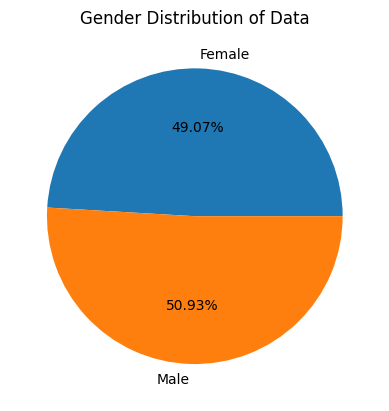

In [83]:
genders = ['Female', 'Male']
weights = [counter_fc+counter_fnc, counter_mc + counter_mnc]
fig,ax = plt.subplots()
ax.pie(weights, labels=genders, autopct = '%1.2f%%')
plt.title('Gender Distribution of Data')
plt.show()


Then, I created a pie chart show the relationship between gender and cancer diagnosis. Despite the almost 50/50 gender split, the percentage of females with cancer was double the percentage of males with cancer. According to the National Institute of Health, "in cancer, susceptibility is generally higher in males although some cancers are more common in women." The dataset does not specify the type of cancer that the patient has, so perhaps this could be influencing the outcome. 

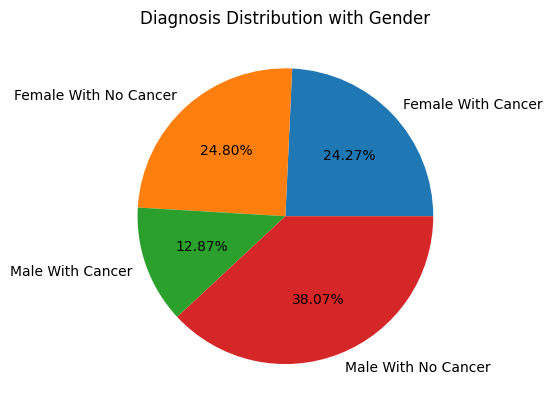

In [84]:

genders_diagnosis = ['Female With Cancer', 'Female With No Cancer', 'Male With Cancer', 'Male With No Cancer']
weights_c = [counter_fc,counter_fnc, counter_mc, counter_mnc]
fig,ax = plt.subplots()
ax.pie(weights_c, labels=genders_diagnosis, autopct = '%1.2f%%')
plt.title('Diagnosis Distribution with Gender')
plt.show()

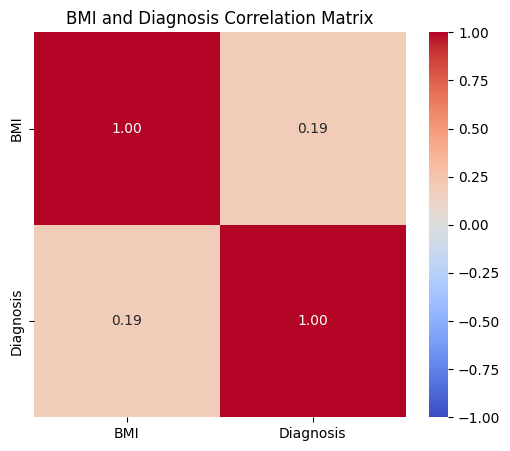

In [85]:
plt.figure(figsize=(6, 5))

sns.heatmap(df[['BMI', 'Diagnosis']].corr(), cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("BMI and Diagnosis Correlation Matrix")
plt.show()

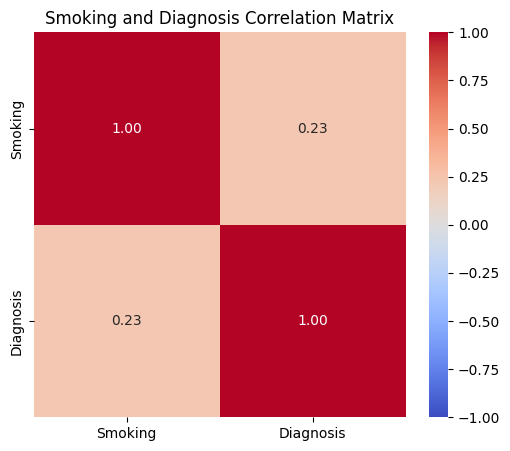

In [86]:
plt.figure(figsize=(6, 5))

sns.heatmap(df[['Smoking', 'Diagnosis']].corr(), cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("Smoking and Diagnosis Correlation Matrix")
plt.show()

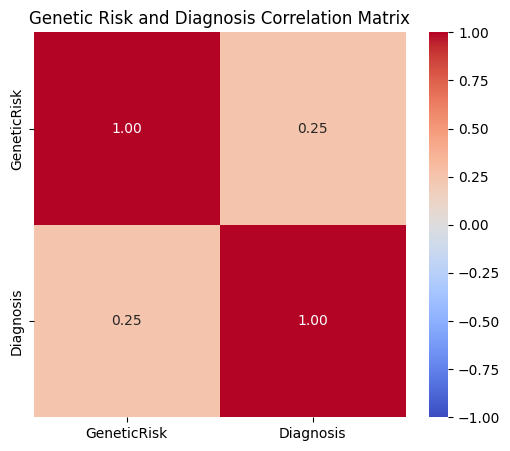

In [87]:
plt.figure(figsize=(6, 5))

sns.heatmap(df[['GeneticRisk', 'Diagnosis']].corr(), cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("Genetic Risk and Diagnosis Correlation Matrix")
plt.show()

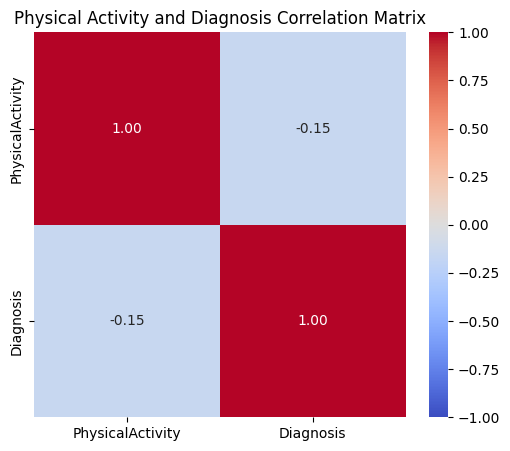

In [88]:
plt.figure(figsize=(6, 5))

sns.heatmap(df[['PhysicalActivity', 'Diagnosis']].corr(), cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("Physical Activity and Diagnosis Correlation Matrix")
plt.show()

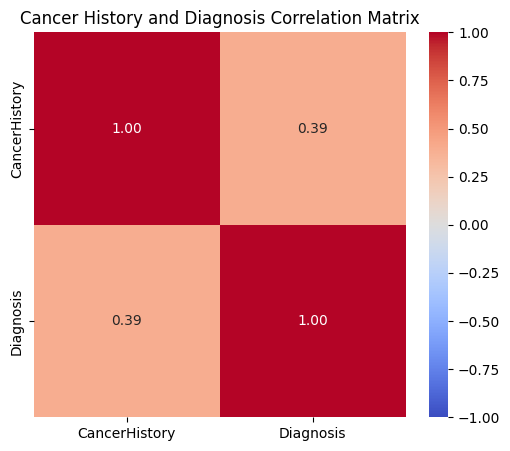

In [89]:
plt.figure(figsize=(6, 5))

sns.heatmap(df[['CancerHistory', 'Diagnosis']].corr(), cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("Cancer History and Diagnosis Correlation Matrix")
plt.show()

The correlation matrix shows that there is a strong positive correlation between developing cancer again once you have had it in the past. Since this was the highest absolute correlation between a feature and diagnosis, I wanted to look more at the data. 

In [73]:
counter_hhc, counter_nhc, counter_hhnc, counter_nhnc = 0,0,0,0
cancerhistory_list = list(df['CancerHistory'])
diagnosis_list = list(df['Diagnosis'])
for i in range(len(diagnosis_list)):
    if cancerhistory_list[i] == 1 and diagnosis_list[i] == 1:
        # if patient has cancer history and has cancer
        counter_hhc += 1
    elif cancerhistory_list[i] == 0 and diagnosis_list[i] == 1:
        # if patient has no cancer history and has cancer 
        counter_nhc += 1
    elif cancerhistory_list[i] == 1 and diagnosis_list[i] == 0:
        # if patient has cancer history and has no cancer
        counter_hhnc
    elif cancerhistory_list[i] == 0 and diagnosis_list[i] == 0:
        # if patient has no cancer history and no cancer 
        counter_nhnc += 1

Research shows that "although the risk is low, cancer survivors have a slightly higher chance of developing a second cancer compared to people of the same age who haven't had cancer" (Canadian Cancer Institute). Certain types of treatment, like radiation therapy and chemo, can increase the risk of a second cancer. The correlation matrix suggests a much stronger relationship between cancer history and cancer diagnosis. I created some pie charts to look deeper at the data. 

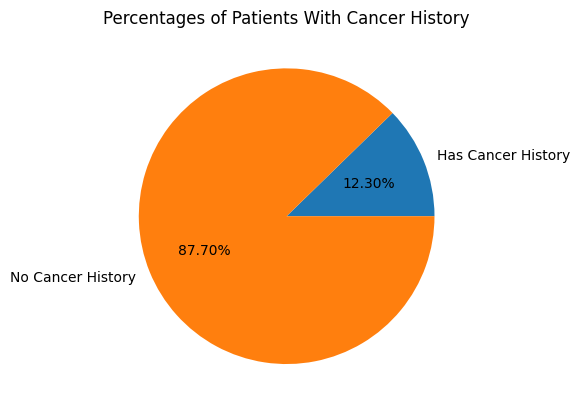

In [124]:
genders = ['Has Cancer History', 'No Cancer History']
weights = [counter_hhc+counter_hhnc, counter_nhc + counter_nhnc]
fig,ax = plt.subplots()
ax.pie(weights, labels=genders, autopct = '%1.2f%%')
plt.title('Percentages of Patients With Cancer History')
plt.show()

The percentage of patients with cancer history and those without history are not evenly distributed in the dataset. Those with no cancer history account for almost 90% of the represented patients. 

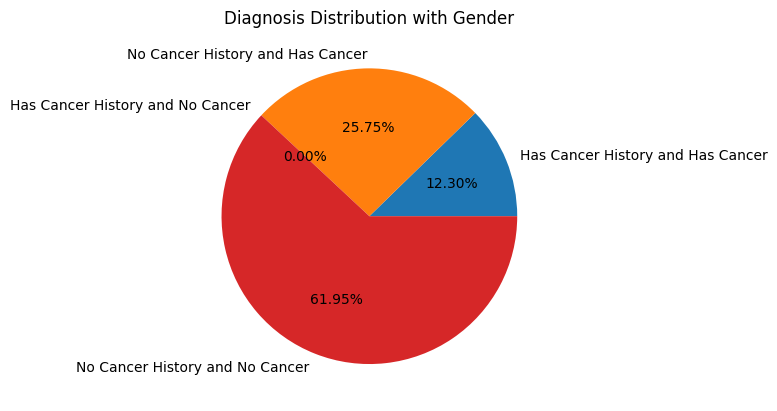

In [75]:
cancerhistory_diagnosis = ['Has Cancer History and Has Cancer', 'No Cancer History and Has Cancer', 'Has Cancer History and No Cancer', 'No Cancer History and No Cancer']
weights_ch = [counter_hhc, counter_nhc, counter_hhnc, counter_nhnc]
fig,ax = plt.subplots()
ax.pie(weights_ch, labels=cancerhistory_diagnosis , autopct = '%1.2f%%')
plt.title('Diagnosis Distribution with Gender')
plt.show()

In fact, in the dataset all of the people with cancer history were diagnosed with cancer. This could be the reason for the very high correlation between cancer history and cancer diagnosis. 

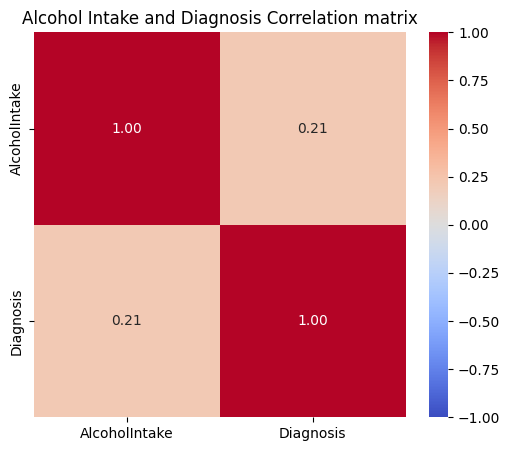

In [41]:
plt.figure(figsize=(6, 5))

sns.heatmap(df[['AlcoholIntake', 'Diagnosis']].corr(), cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("Alcohol Intake and Diagnosis Correlation Matrix")
plt.show()

# **Split Into Train and Test + Define Label**

In [5]:
feature_list = list(df.columns)[:-1]
feature_list

['Age',
 'Gender',
 'BMI',
 'Smoking',
 'GeneticRisk',
 'PhysicalActivity',
 'AlcoholIntake',
 'CancerHistory']

In [6]:
y = df['Diagnosis']
X = df[feature_list]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=1234)

# **Logistic Regression Model**

In [33]:
logr_param_grid = dict(C = [10**i for i in range(-5,5)])
logr_param_grid

{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

In [34]:
print('Running Grid Search...')

# 1. Create a LogisticRegression model object with the argument max_iter=1000. 

logr_model = LogisticRegression(max_iter=1000)


# 2. Run a grid search with 5-fold cross-validation 
logr_grid = GridSearchCV(logr_model, logr_param_grid, cv=5)


# 3. Fit the model on the training data 
logr_grid_search = logr_grid.fit(X_train, y_train)

print('Done')

Running Grid Search...
Done


In [35]:
best_c = logr_grid_search.best_params_['C']
best_c

100

In [41]:
def train_test_LogR(X_train, y_train, X_test, y_test, c=best_c):
    '''Fit a Linear Regression classifier to the training data X_train, y_train.
    Return the loss and accuracy of resulting predictions on the test set.
    Parameters:
    C = Factor that controls how much regularization is applied to the␣
    ↪→model.
    '''
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


    logr_model = LogisticRegression(C=c)

    logr_model.fit(X_train, y_train)

    probability_predictions = logr_model.predict_proba(X_test)

    l_loss = log_loss(y_test, probability_predictions)

    lr_class_label_predictions = logr_model.predict(X_test)
    
    coefficients = logr_model.coef_

    

    acc_score = accuracy_score(y_test, lr_class_label_predictions)
    return coefficients, lr_class_label_predictions


In [46]:
coefficients, lr_class_label_predictions = train_test_LogR(X_train, y_train, X_test, y_test, c=best_c)

In [47]:
coefficients[0]

array([ 0.9106465 ,  1.04925558,  0.93094173,  0.88428759,  1.06325742,
       -0.68545854,  0.87554341,  1.5672453 ])

<Axes: title={'center': 'LogR Feature Importance'}, ylabel='Feature'>

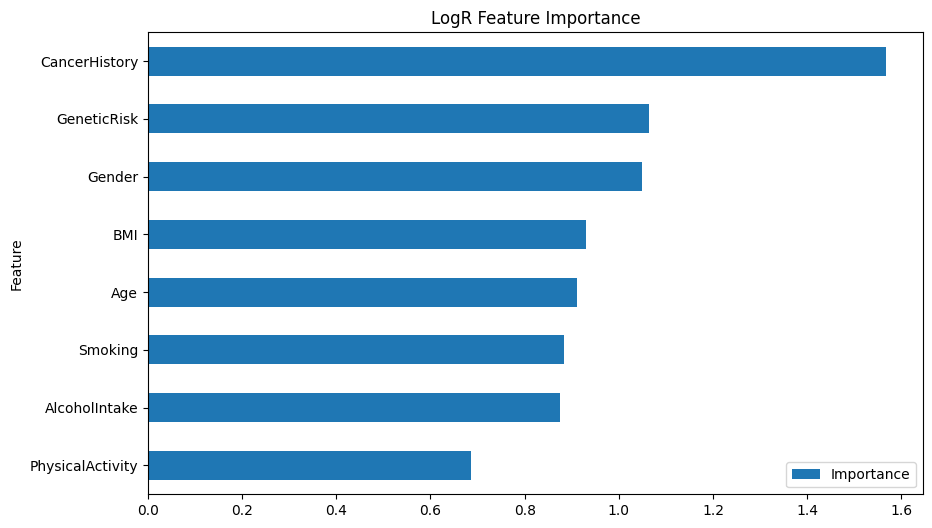

In [65]:
logr_feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients[0])})
logr_feature_importance = logr_feature_importance.sort_values('Importance', ascending=True)
logr_feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6), title = 'LogR Feature Importance')

In [66]:
logr_acc = accuracy_score(y_test, lr_class_label_predictions)
print('Logistic Regression Accuracy: ' + str(logr_acc))

Logistic Regression Accuracy: 0.8626262626262626


In [67]:
c_m = confusion_matrix(y_test, lr_class_label_predictions, labels=[True,False])
pd.DataFrame(
c_m,
columns=['Predicted: Has Cancer', 'Predicted: No Cancer'],
index=['Actual: Has Cancer', 'Actual: No Cancer'])

,Predicted: Has Cancer,Predicted: No Cancer
Actual: Has Cancer,144,37
Actual: No Cancer,31,283


# **Decision Tree Classifier Model**

In [52]:
dt_md = [2, 64]
dt_msl = [25, 100]
dt_param_grid={'max_depth':dt_md, 'min_samples_leaf':dt_msl}

In [53]:
print('Running Grid Search...')

# 1. Create a DecisionTreeClassifier model 

dt_model = DecisionTreeClassifier()


# 2. Run a grid search with 5-fold cross-validation 

dt_grid = GridSearchCV(dt_model, dt_param_grid, cv=5)


# 3. Fit the model on the training data 

dt_grid_search = dt_grid.fit(X_train, y_train)

print('Done')

Running Grid Search...
Done


In [54]:
best_dt = dt_grid_search.best_params_
best_dt
depth_dt = best_dt['max_depth']
leaf_dt = best_dt['min_samples_leaf']


In [68]:
def train_test_DT(X_train, X_test, y_train, y_test, leaf_dt, depth_dt, crit='entropy'):
    '''
    Fit a Decision Tree classifier to the training data X_train, y_train.
    Return the accuracy of resulting predictions on the test set.
    Parameters:
        leaf := The minimum number of samples required to be at a leaf node 
        depth := The maximum depth of the tree
        crit := The function to be used to measure the quality of a split. Default: gini.
    '''
        
    

     # 1. Create the  DecisionTreeClassifier model object below 
    dt_model = DecisionTreeClassifier(criterion = crit, max_depth = depth_dt, min_samples_leaf = leaf_dt)
    
    # 2. Fit the model to the training data below
    dt_model.fit(X_train, y_train)
    
    # 3. Make predictions on the test data below 
    dt_class_label_predictions= dt_model.predict(X_test)
    dt_importances = dt_model.feature_importances_
    # 4. Compute the accuracy here 
    dt_acc = accuracy_score(y_test, dt_class_label_predictions)
    
    
    return dt_acc, dt_importances, dt_class_label_predictions

In [69]:
dt_acc, dt_importances, dt_class_label_predictions = train_test_DT(X_train, X_test, y_train, y_test, leaf_dt, depth_dt, crit='entropy')

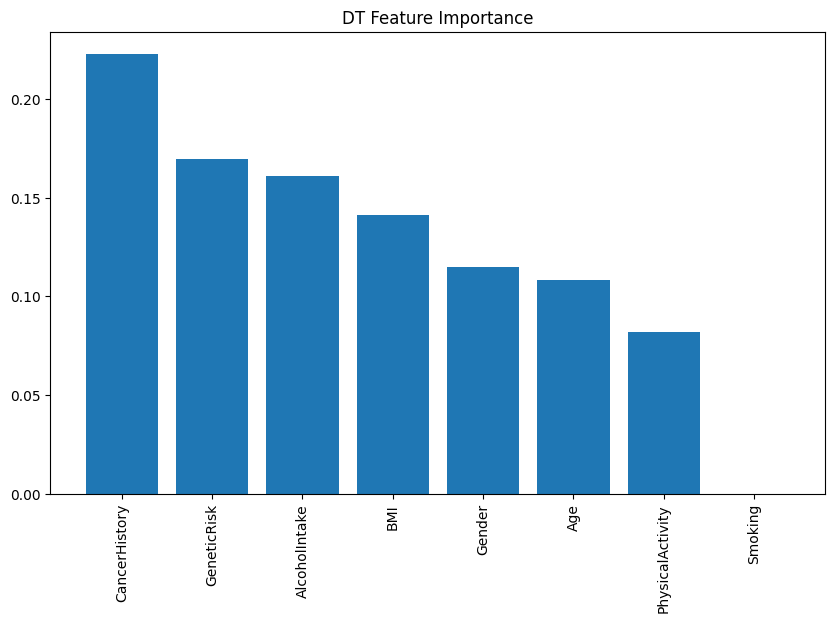

In [70]:
indices = np.argsort(dt_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("DT Feature Importance")
plt.bar(range(X_train.shape[1]), dt_importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)
plt.show()
    

In [71]:
c_m = confusion_matrix(y_test, dt_class_label_predictions, labels=[True,False])
pd.DataFrame(
c_m,
columns=['Predicted: Has Cancer', 'Predicted: No Cancer'],
index=['Actual: Has Cancer', 'Actual: No Cancer'])

,Predicted: Has Cancer,Predicted: No Cancer
Actual: Has Cancer,141,40
Actual: No Cancer,36,278


In [72]:
print("Decision Tree Classifier Accuracy:" ,dt_acc)

Decision Tree Classifier Accuracy: 0.8464646464646465


# **Stacking Ensemble Model**

In [78]:
estimators = [("DT", DecisionTreeClassifier(max_depth=depth_dt, min_samples_leaf=leaf_dt)),
("LogR", LogisticRegression(C=best_c))
]

In [79]:
print('Implement Stacking...')

stacking_model = StackingClassifier(estimators=estimators,
passthrough=False)
stacking_model.fit(X_train, y_train)

print('End')

Implement Stacking...
End


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [80]:
stacking_pred = stacking_model.predict(X_test)
stacking_acc = accuracy_score(y_test, stacking_pred)

In [81]:
c_m = confusion_matrix(y_test, stacking_pred, labels=[True,False])
pd.DataFrame(
c_m,
columns=['Predicted: Has Cancer', 'Predicted: No Cancer'],
index=['Actual: Has Cancer', 'Actual: No Cancer'])

,Predicted: Has Cancer,Predicted: No Cancer
Actual: Has Cancer,151,30
Actual: No Cancer,29,285


In [82]:
print("Stacking Model Accuracy:", stacking_acc)

Stacking Model Accuracy: 0.8808080808080808


# **Gradient Boost Decision Trees Model**

In [18]:
GBDT_param_grid={"learning_rate": [.12, .13],
    "max_depth":[1],
    "subsample":[0.87],
    "n_estimators":range(150,200)}

Tried randomized search to find best hyperparameters

In [11]:
GBDT_model = GradientBoostingClassifier()
rs = RandomizedSearchCV(GBDT_model, param_distributions=GBDT_param_grid,
                        n_iter=10, scoring="accuracy", random_state=0,
                        n_jobs=-1, cv=5, return_train_score=True)
rs.fit(X_train, y_train)
rs.best_params_

{'subsample': 0.87, 'n_estimators': 168, 'max_depth': 1, 'learning_rate': 0.12}

Also tried grid search to find best hyperparameters which I found was slightly better in terms of accuracy

In [19]:
print('Running Grid Search...')

# 1. Create a GradientBoostingClassifier model object 

GBDT_model = GradientBoostingClassifier()


# 2. Run a grid search with 5-fold cross-validation 
GBDT_grid = GridSearchCV(GBDT_model, GBDT_param_grid, cv=5)


# 3. Fit the model on the training data
GBDT_grid_search = GBDT_grid.fit(X_train, y_train)

print('Done')

Running Grid Search...
Done


In [20]:
best_GBDT = GBDT_grid_search.best_params_
best_GBDT

{'learning_rate': 0.12, 'max_depth': 1, 'n_estimators': 153, 'subsample': 0.87}

In [27]:
GBDT_model = GradientBoostingClassifier(max_depth = 1,
n_estimators = 153, learning_rate = .12, subsample = .87)
GBDT_model.fit(X_train, y_train)
print('End')

End


In [28]:
y_GBDT_pred = GBDT_model.predict(X_test)

In [29]:
GBDT_importances = GBDT_model.feature_importances_

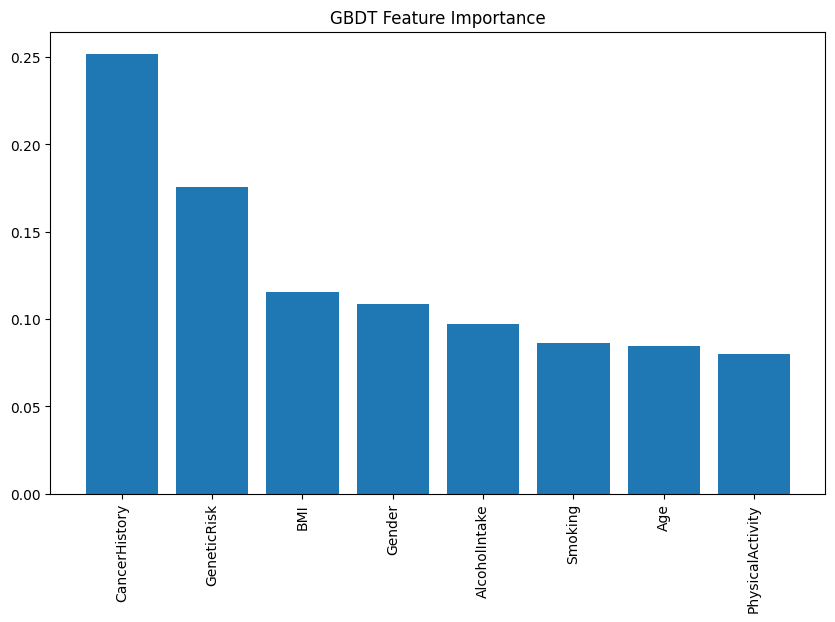

In [84]:
indices = np.argsort(GBDT_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("GBDT Feature Importance")
plt.bar(range(X_train.shape[1]), GBDT_importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)
plt.show()
    

In [31]:
c_m = confusion_matrix(y_test, y_GBDT_pred, labels=[True,False])
pd.DataFrame(
c_m,
columns=['Predicted: Has Cancer', 'Predicted: No Cancer'],
index=['Actual: Has Cancer', 'Actual: No Cancer'])

,Predicted: Has Cancer,Predicted: No Cancer
Actual: Has Cancer,167,14
Actual: No Cancer,5,309


In [32]:
GBDT_acc = accuracy_score(y_test, y_GBDT_pred)
print("Gradient Boost Decision Trees Accuracy:", GBDT_acc)

Gradient Boost Decision Trees Accuracy: 0.9616161616161616


# **Random Forest Model**

In [6]:
md = range(1, 24)
n_est = [100,600]
rf_param_grid={'max_depth':md, 'n_estimators':n_est, 'min_samples_leaf': [2,32]}

In [7]:
print('Running Grid Search...')

# 1. Create a LogisticRegression model object with the argument max_iter=1000. 

rf_model = RandomForestClassifier()


# 2. Run a grid search with 5-fold cross-validation
rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=5)


# 3. Fit the model on the training data
rf_grid_search = rf_grid.fit(X_train, y_train)

print('Done')

Running Grid Search...
Done


In [8]:
best_rf = rf_grid_search.best_params_
best_rf

{'max_depth': 23, 'min_samples_leaf': 2, 'n_estimators': 600}

In [14]:
rf_model = RandomForestClassifier(max_depth = 23,
n_estimators = 600, min_samples_leaf = 2)
rf_model.fit(X_train, y_train)
print('End')

End


In [15]:
y_rf_pred = rf_model.predict(X_test)

In [16]:
rf_importances = rf_model.feature_importances_

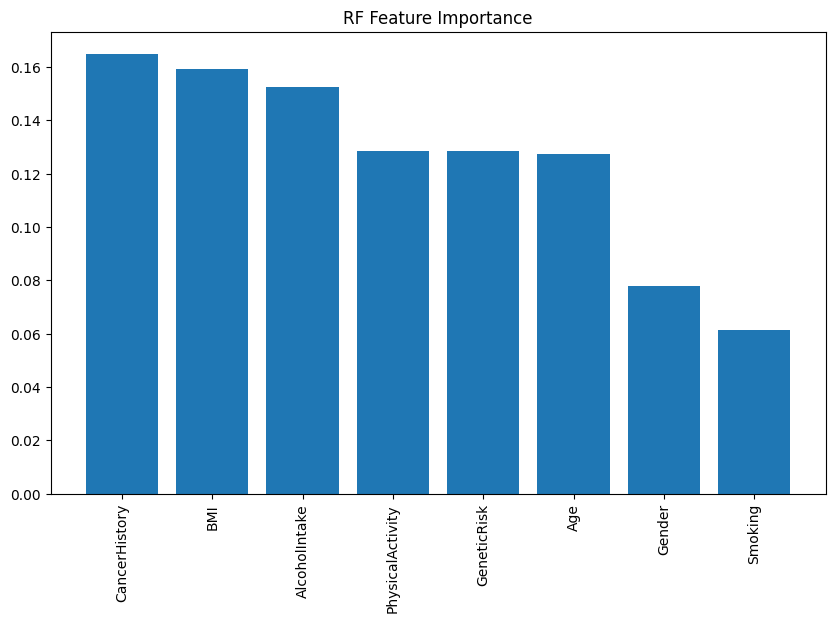

In [83]:
indices = np.argsort(rf_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("RF Feature Importance")
plt.bar(range(X_train.shape[1]), rf_importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)
plt.show()
    

In [221]:
c_m = confusion_matrix(y_test, y_rf_pred, labels=[True,False])
pd.DataFrame(
c_m,
columns=['Predicted: Has Cancer', 'Predicted: No Cancer'],
index=['Actual: Has Cancer', 'Actual: No Cancer'])

,Predicted: Has Cancer,Predicted: No Cancer
Actual: Has Cancer,160,21
Actual: No Cancer,16,298


In [222]:

rf_acc = accuracy_score(y_test, y_rf_pred)
print("Random Forest Accuracy:", rf_acc)

Random Forest Accuracy: 0.9252525252525252


# **Comparing Model Performance**

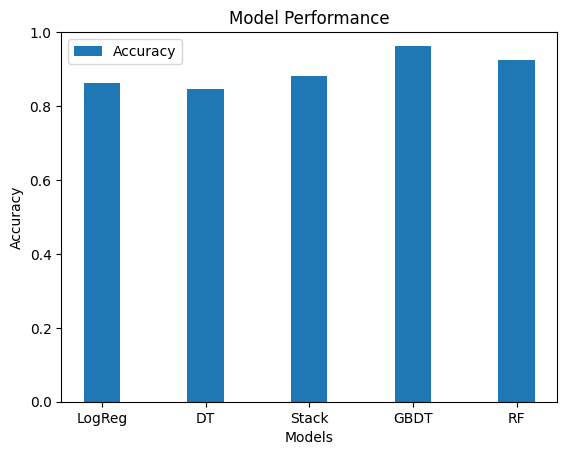

In [223]:
Accuracy_Results = [logr_acc, dt_acc, stacking_acc, GBDT_acc, rf_acc]
rg= np.arange(5)
width = 0.35

plt.bar(rg, Accuracy_Results, width, label="Accuracy")

labels = ['LogReg','DT', 'Stack', 'GBDT', 'RF']
plt.xticks(rg, labels)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.ylim([0,1])
plt.title('Model Performance')
plt.legend(loc='upper left', ncol=2)
plt.show()

# **Highest Accuracy: 96 %**

# **Model: GBDT %**

The model that performed the best was the GBDT model, with an accuracy of 96 percent. All of the ensemble models performed better than the models that were not ensemble models. 